In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu

# Load the CSV file
file_path = 'final_generated_responses_corrected.csv'
data = pd.read_csv(file_path)

# Define Jaccard similarity function
def jaccard_similarity(doc1, doc2):
    words_doc1 = set(doc1.split()) 
    words_doc2 = set(doc2.split())
    intersection = words_doc1.intersection(words_doc2)
    union = words_doc1.union(words_doc2)
    return float(len(intersection)) / len(union)

# Define custom ROUGE-L function
def calculate_rouge_l(reference, candidate):
    reference_tokens = reference.split()
    candidate_tokens = candidate.split()
    reference_len = len(reference_tokens)
    candidate_len = len(candidate_tokens)
    
    dp = [[0] * (candidate_len + 1) for _ in range(reference_len + 1)]
    
    for i in range(reference_len + 1):
        for j in range(candidate_len + 1):
            if i == 0 or j == 0:
                dp[i][j] = 0
            elif reference_tokens[i-1] == candidate_tokens[j-1]:
                dp[i][j] = dp[i-1][j-1] + 1
            else:
                dp[i][j] = max(dp[i-1][j], dp[i][j-1])
                
    lcs_len = dp[reference_len][candidate_len]
    precision = lcs_len / candidate_len if candidate_len > 0 else 0
    recall = lcs_len / reference_len if reference_len > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return f1_score

# Vectorize text for cosine similarity
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data[['generated_response_prompt1', 'generated_response_prompt2', 'physician_comments']].values.flatten())

# Calculate cosine similarities
cosine_similarities = cosine_similarity(tfidf_matrix)
similarity_results = pd.DataFrame(data['id'], columns=['id'])

# Calculating all similarities
similarity_functions = [cosine_similarity, jaccard_similarity, sentence_bleu, calculate_rouge_l]
labels = ['Cosine', 'Jaccard', 'BLEU', 'ROUGE_L']

# Calculate all pairwise comparisons
for func, label in zip(similarity_functions, labels):
    # Define the pairs for comparison
    pairs = [('generated_response_prompt1', 'generated_response_prompt2'),
             ('generated_response_prompt1', 'physician_comments'),
             ('generated_response_prompt2', 'physician_comments')]
    
    for pair in pairs:
        col_name = f'{label}_Sim_{pair[0][-1]}_{pair[1][-1]}'  # Correct column name creation based on prompts and comments
        if func == cosine_similarity:
            similarity_results[col_name] = [
                func(tfidf_vectorizer.transform([row[pair[0]]]), 
                     tfidf_vectorizer.transform([row[pair[1]]]))[0, 0]
                for index, row in data.iterrows()
            ]
        else:
            similarity_results[col_name] = [
                func(row[pair[0]], row[pair[1]])
                for index, row in data.iterrows()
            ]

similarity_results.head()


/Users/dhirpalshah/miniconda3/envs/condavenv/lib/python3.8/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/dhirpalshah/miniconda3/envs/condavenv/lib/python3.8/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/dhirpalshah/miniconda3/envs/condavenv/lib/python3.8/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lowe

,id,Cosine_Sim_1_2,Cosine_Sim_1_s,Cosine_Sim_2_s,Jaccard_Sim_1_2,Jaccard_Sim_1_s,Jaccard_Sim_2_s,BLEU_Sim_1_2,BLEU_Sim_1_s,BLEU_Sim_2_s,ROUGE_L_Sim_1_2,ROUGE_L_Sim_1_s,ROUGE_L_Sim_2_s
0,1i7s0u,0.632732,0.167837,0.176242,0.233983,0.086379,0.116719,6.797190e-232,8.368341e-232,8.368341e-232,0.214976,0.088028,0.094737
1,1i7qst,0.689079,0.258419,0.439947,0.260652,0.115942,0.135048,6.420645e-232,8.859356e-232,8.859356e-232,0.272637,0.096718,0.092025
2,1i7hzo,0.481272,0.301546,0.243571,0.210784,0.081911,0.104730,6.561680e-232,9.405151e-232,9.342655e-232,0.143713,0.067797,0.077348
3,1iawxh,0.368036,0.181209,0.223521,0.114441,0.078067,0.103321,6.848004e-232,8.256980e-232,8.456086e-232,0.129801,0.074074,0.117137
4,1i9v7i,0.387593,0.203380,0.231738,0.177945,0.093093,0.147059,6.950441e-232,8.532517e-232,8.414799e-232,0.141317,0.080257,0.113924


In [5]:
similarity_results.to_csv("final_analysis.csv", index=False)

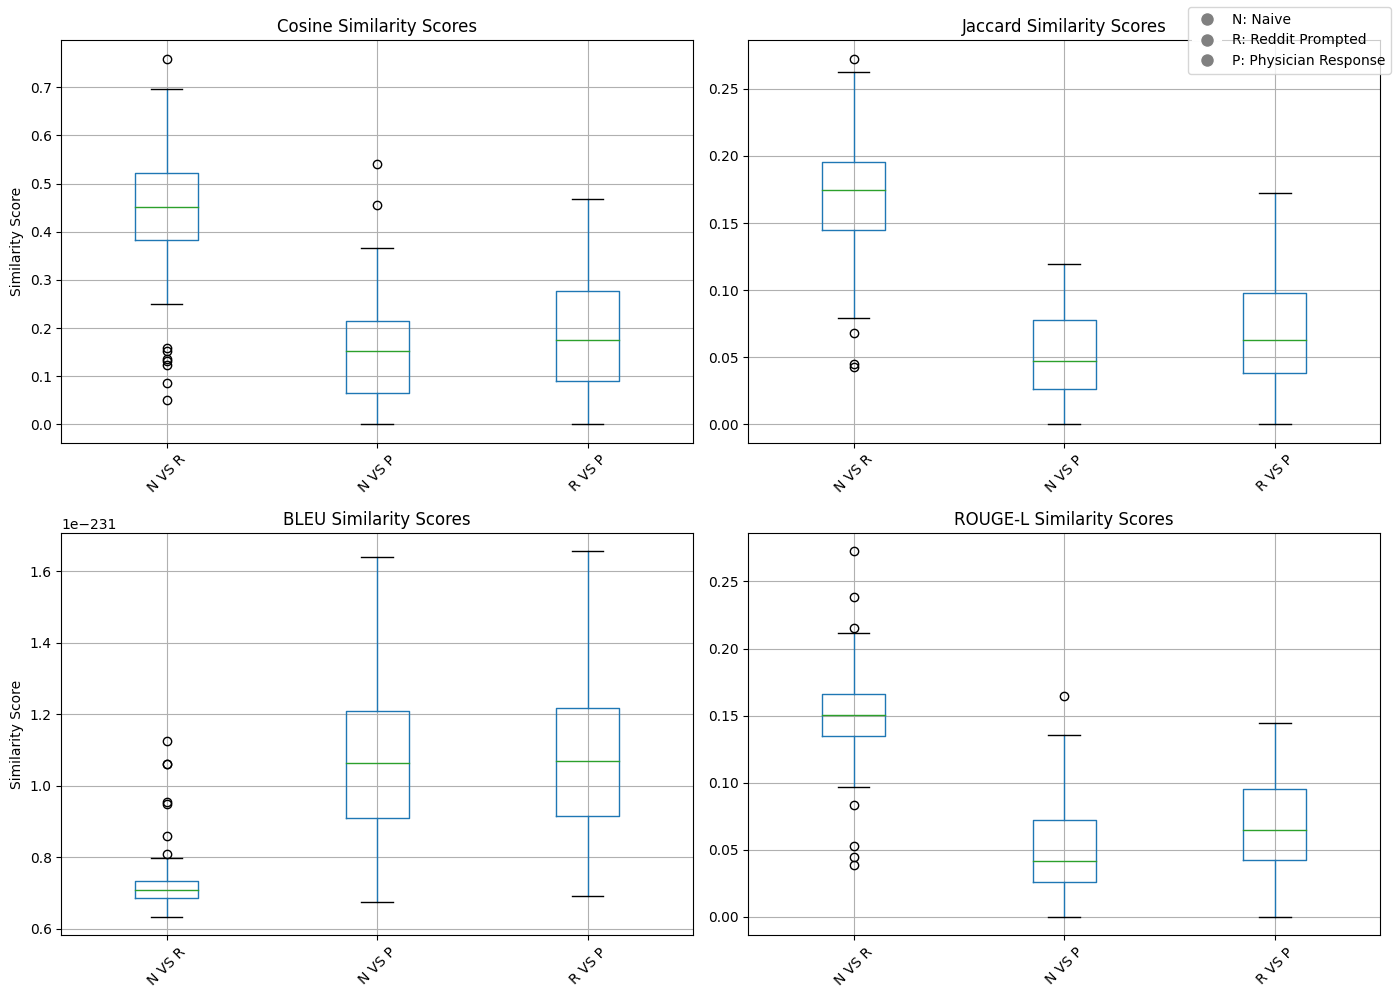

In [10]:
import matplotlib.pyplot as plt

final_analysis_path = 'final_analysis.csv'
final_analysis_data = pd.read_csv(final_analysis_path)
final_analysis_data.head()

# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharey=False)

# Cosine similarity plots
cosine_cols = [col for col in final_analysis_data.columns if 'Cosine' in col]

# Jaccard similarity plots
jaccard_cols = [col for col in final_analysis_data.columns if 'Jaccard' in col]

# BLEU similarity plots
bleu_cols = [col for col in final_analysis_data.columns if 'BLEU' in col]

# ROUGE-L similarity plots
rouge_cols = [col for col in final_analysis_data.columns if 'ROUGE_L' in col]

# Update labels to be more intuitive and descriptive
rename_labels = {
    '1': 'N',
    '2': 'R',
    's': 'P'
}

# Function to rename axis labels
def rename_axis_labels(labels):
    new_labels = []
    for label in labels:
        parts = label.split('_')
        new_label = f'{rename_labels[parts[-2][0]]} VS {rename_labels[parts[-1][0]]}'
        new_labels.append(new_label)
    return new_labels

# Cosine similarity plots with new labels
final_analysis_data[cosine_cols].boxplot(ax=axs[0, 0])
axs[0, 0].set_title('Cosine Similarity Scores')
axs[0, 0].set_ylabel('Similarity Score')
axs[0, 0].set_xticklabels(rename_axis_labels(cosine_cols), rotation=45)

# Jaccard similarity plots with new labels
final_analysis_data[jaccard_cols].boxplot(ax=axs[0, 1])
axs[0, 1].set_title('Jaccard Similarity Scores')
axs[0, 1].set_xticklabels(rename_axis_labels(jaccard_cols), rotation=45)

# BLEU similarity plots with new labels
final_analysis_data[bleu_cols].boxplot(ax=axs[1, 0])
axs[1, 0].set_title('BLEU Similarity Scores')
axs[1, 0].set_ylabel('Similarity Score')
axs[1, 0].set_xticklabels(rename_axis_labels(bleu_cols), rotation=45)

# ROUGE-L similarity plots with new labels
final_analysis_data[rouge_cols].boxplot(ax=axs[1, 1])
axs[1, 1].set_title('ROUGE-L Similarity Scores')
axs[1, 1].set_xticklabels(rename_axis_labels(rouge_cols), rotation=45)

# Create legend explaining each label
labels = ['N: Naive', 'R: Reddit Prompted', 'P: Physician Response']
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                      markerfacecolor='gray', markersize=10) for label in labels]
fig.legend(handles=handles, loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()

